# Boundary Conditiond and Finite Differences 

This notebook explains how to enforce boundary conditions (BC) that involve derivatives. Such conditions are called [Neumann](https://en.wikipedia.org/wiki/Neumann_boundary_condition) or [Robin](https://en.wikipedia.org/wiki/Robin_boundary_condition) BC, depending on whether they involve the derivative alone (Neumann) or a linear combination of derivative and function value (Robin).

In [1]:
# Import things we'll need
from math import pi, cos, tan, fabs, exp
from scipy.linalg import solve_banded
from numba import njit

import numpy as np
import matplotlib.pyplot as plt

### A test problem

As a running example, I'll solve the heat equation

$$
    \frac{\partial U}{\partial t} = \frac{\partial^2 U}{\partial x^2}
$$

on the domain $0 \leq x \leq 1$ with $t \geq 0$, initial condition $U(x,0) = 1$ and BC 

$$
    \frac{\partial U}{\partial x} = U \;\; \mbox{at $x=0$} \qquad \mbox{and} \qquad 
    \frac{\partial U}{\partial x} = -U \;\; \mbox{at $x=1$}
$$

for all $t \geq 0$. 

This problem is discussed on pages 29&ndash;38 of 

> GD Smith (), Numerical Solution of PDEs: Finite Difference Methods, 3rd ed., OUP.

and has analytic solution

$$
U = 4 \sum_{n=0}^\infty \frac{\sec(\alpha_n)}{3 + 4 \alpha_n^2} \, e^{-4 \alpha_n^2 t} \cos\left(2 \alpha_n (x - \frac{1}{2}) \right),
$$
where the $\alpha_n$ are the (infinitley many) positive solutions to $\alpha \tan(\alpha) = 1/2$.

Note that, in contrast to a typical option-pricing problem, this is a _forward_ heat equation and so we are given data at $t=0$ and want to propagate the solution forward in time, rather than backward from some known final payoff.

#### Code for the analytic solution

We begin by computing the $\alpha_n$. To see how this works, rewrite the defining equation as
$
\displaystyle
\tan(\alpha) = \frac{1}{2 \alpha}
$
and then plot the left- and righthand sides of this equation on the same axes.

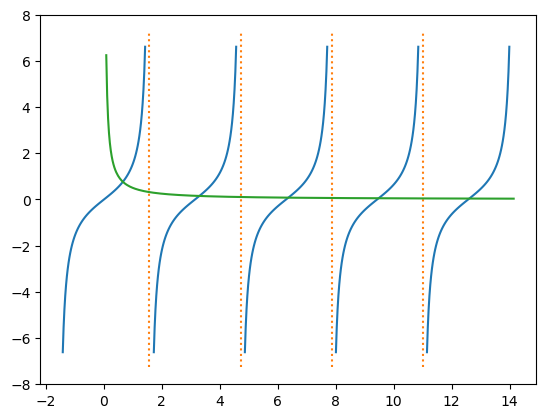

In [2]:
# Get ready to plot a cycle of the tangent
nSteps = 100
eps = 0.15 # keep away from singularities
alphaVals = np.linspace( start=-0.5*pi + eps, stop=0.5*pi - eps, num=(nSteps+1))
tanVals = np.array([tan(alpha) for alpha in alphaVals])

# Plot several cycles on the same axes
nCycles = 5
for j in range(nCycles):
    plt.plot( j*pi + alphaVals, tanVals, c='C0' )

# Add dotted vertical lines at the singularities
xmin, xmax, ymin, ymax = plt.axis()
for j in range(nCycles-1):
    plt.vlines( x=(j + 0.5)*pi, ymin=ymin, ymax=ymax, colors='C1', linestyles='dotted' )

# Add a curve for 1/(2 * alpha)
eps = 0.08
alphaVals = np.linspace( start=eps, stop=(nCycles - 0.5)*pi, num=int((nCycles - 0.5)*nSteps)+1)
curveVals = np.array([1.0/(2 * alpha) for alpha in alphaVals])
plt.plot( alphaVals, curveVals, c='C2' )


Here the curves for $\tan(\alpha)$ are blue, while $1/(2 \alpha)$ is plotted in green. The dotted vertical lines at $\alpha = n*\pi + \pi/2$ indicate singularities of $\tan(\alpha)$.

The plot makes it clear that the $\alpha_n$ are near $n\pi$ for $n = 0, 1, 2, \dots$, so we can seek them using Newton's method.

In [3]:
@njit
def findAlpha( n, maxCycles=20, tol=1.0e-12 ):
    # Choose an initial guess
    if( n > 0):
        alpha = n*pi
    else:
        alpha = 1.0

    # Use Newton's method to find a solution of alpha*tan(alpha) - 0.5 = 0
    nCycles = 0
    val = alpha * tan(alpha) - 0.5
    while (nCycles < maxCycles) and (fabs(val) > tol):
        deriv = tan(alpha) + alpha/(cos(alpha)*cos(alpha))
        alpha -= val/deriv
        val = alpha * tan(alpha) - 0.5
        nCycles += 1

    return( alpha )

# Do a small test: the result should be near 1.0
findAlpha(1) / pi

1.0479748281560544

In [4]:
nTerms = 100 # We need to truncate the infinite sum
alphaVals = np.array( [findAlpha(n) for n in range(nTerms)] )
alphaVals[0:5] / pi # for n > 0, alpha_n should be near n*pi

array([0.20794268, 1.04797483, 2.02496666, 3.0167774 , 4.0126187 ])

Once we have the $\alpha_n$, we can write a function to evaluate the analytic solution.

In [5]:
@njit
def analyticSolution(x, t, alphaVals):
    if t == 0:
        result = 1.0 
    else:
        result = 0.0
        for alpha in alphaVals:
            alphaSq = alpha*alpha
            coef = 4.0 / ((3.0 + 4.0*alphaSq)*cos(alpha))
            term = coef * exp(-4.0*alphaSq*t) * cos(2.0*alpha*(x - 0.5))
            result += term

    return( result )

The plot below shows curves $U(x,t)$ for $0 \leq x \leq 1$ at various values of $t$. $U(x,t)$ relaxes to 0 fairly rapidly.

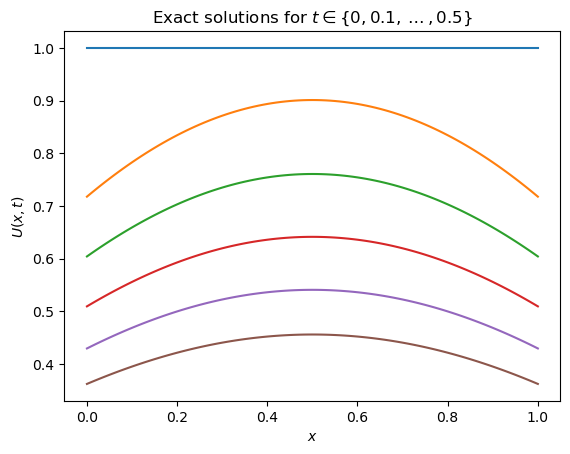

In [6]:
tMax = 0.5
tVals = np.linspace( 0.0, tMax, 6 )
xVals = np.linspace( 0.0, 1.0, nSteps+1 )
for t in tVals:
    uVals = np.array( [analyticSolution(x, t, alphaVals) for x in xVals] )
    plt.plot( xVals, uVals )

plt.xlabel( "$x$" )
plt.ylabel( "$U(x, t)$" )
plt.title( "Exact solutions for $t \\in \\{0, 0.1, \\dots, 0.5\\}$" )
plt.show()

## A first Crank-Nicolson scheme

We now want to solve the PDE numerically using a Crank-Nicolson scheme. If we write $U^{i}_j$ to mean
$U(x=j\Delta x, \, t=i\Delta t)$, then the usual sorts of calculation (see, for example, [solutions](https://github.com/VenetianRed/MATH60082-python/blob/main/solutions/MATH60082-lab-solution-9.ipynb) from the lab for Week&nbsp;9) the lead to
$$
\frac{\partial U}{\partial t} \approx \frac{U_j^{i+1}-U_j^i}{\Delta t}
$$
and
$$
\frac{\partial^2 U}{\partial x^2} \approx 
\frac{1}{2\Delta x^2}(U^i_{j+1}-2U_j^i
+U^i_{j-1}+U_{j+1}^{i+1}-2U_j^{i+1}
+U_{j-1}^{i+1})
$$
where the partial derivatives are imagined to be evaluated at points $(j\times \Delta x, \, (i + 1/2)\times \Delta t)$ and the finite-difference approximations are accurate to $O(\Delta t^2)$ and
$O(\Delta x^2)$.

Plugging these into the PDE and rearanging them to put function values from the same time on the same side of the equation yields
$$
    -r U^{i+1}_{j-1} + 2(1 + r)U^{i+1}_{j} - rU^{i+1}_{j+1} = 
    rU^{i}_{j-1} + 2(1 - r)U^{i}_{j} + rU^{i}_{j+1}
$$
where $r = \Delta t / \Delta x^2$. Writing this in the standard Crank-Nicolson way, we find
$$
    a_j U^{i+1}_{j-1} + b_j U^{i+1}_{j} + c_j U^{i+1}_{j+1} = d_j
$$
with
$$
    a_j = -r, \;\;
    b_j = 2(1 + r), \;\;
    c_j = -r \qquad \mbox{and} \qquad 
    d_j = rU^{i}_{j-1} + 2(1 - r)U^{i}_{j} + rU^{i}_{j+1}.
$$

These equations hold for $j \in \{1, \dots, $ `jMax` $-1 \}$ and correspond to demanding that the PDE be satisfied at points with coordinates $(j\times \Delta x, \, (i + 1/2)\times \Delta t)$.

#### Boundary conditions

We now enforce the boundary conditions to get equations for $j = 0$ and $j = $ `jMax`. The simplest approach is to use the $O(\Delta x)$ approximation
$$
    \left. \frac{\partial U}{\partial x} \right|_{x=0, \, t=i\times\Delta t} \approx
    \frac{U^i_{1} - U^i_{0}}{\Delta x} 
$$
so that the boundary condition at $x=0$ becomes
$$ 
\frac{U^{i+1}_{1} - U^{i+1}_{0}}{\Delta x} = U^{i+1}_0
$$
or, multiplying by $\Delta x$ and rearranging,
$$
\begin{align}
    U^{i+1}_{1} - U^{i+1}_{0} & = \Delta x U^{i+1}_0  \\
    (1 + \Delta x)U^{i+1}_0 - U^{i+1}_{1} & = 0
\end{align}
$$
which is of the form
$$
    b_0 U^{i+1}_0 + c_0 U^{i+1}_1 = d_0
$$
with
$$
    b_0 = (1 + \Delta x), \;\;
    c_0 = -1 \qquad \mbox{and} \qquad 
    d_0 = 0.
$$

Similar reasoning applied to the boundary condition at $x=1$ leads to 
$$
    a_{\texttt{jMax}} U^{i+1}_{\texttt{jMax-1}} + b_{\texttt{jMax}} U^{i+1}_{\texttt{jMax}} = d_{\texttt{jMax}}
$$
with
$$
    a_{\texttt{jMax}} = -1, \;\;
    b_{\texttt{jMax}} = 1 + \Delta x \qquad \mbox{and} \qquad 
    d_{\texttt{jMax}} = 0.
$$


As in the lab sessions about Crank-Nicolson, we use  SciPy's `solve_banded()` function to solve $A \boldsymbol{U^{i+1}} = \boldsymbol{d^{i}}$.  See the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_banded.html#scipy.linalg.solve_banded) for more details.

We'll store $A$'s diagonal bands in a $3 \times \mbox{(\texttt{jMax + 1})}$ matrix `A_bands` in such a way that:

* `A_bands[2,j-1]` $= a_{j}$
* `A_bands[1,j]` $= b_j$
* `A_bands[0,j+1]` $= c_j$

This storage pattern is expected by `solve_banded()`, whose documentation says that one should construct a matrix `ab` whose relation to the full matrix `a` is 
```
ab[u + i - j, j] = a[i,j]
```
where `u` is the number of non-empty diagonals above the main one and `l` is the number of non-empty diagonals below the main one: for us, `u = l = 1`.

In [7]:
def HeatEqn_CN1( iMax, jMax, tMax ):
    # Compute the step sizes and r
    xVals = np.linspace( 0.0, 1.0, (jMax + 1) )
    tVals = np.linspace( 0.0, tMax, (iMax + 1) )
    dx = xVals[1] - xVals[0]
    dt = tVals[1] - tVals[0]
    r = dt / (dx * dx) 

    # Set up storage for the tri-diagonal matrix A
    A_bands = np.zeros(shape=(3,jMax+1)) 
    
    # Set up a tuple that described the bands in our matrix
    u=1 # number of bands above the main diagonal
    l=1 # number of bands below the main diagonal
    l_and_u = (l, u) # needed for solve_banded()

    # Enforce the boundary condition at x=0
    A_bands[1,0] = (1.0 + dx) # b_0 = (1 + dx)
    A_bands[0,1] = -1.0 # c_0 = 1
    
    # Set a[j], b[j] and c[j] for the middle rows
    for j in range(1,jMax):
        A_bands[2,j-1] = -r # a_j
        A_bands[1,j] = 2*(1.0+r) # b_j
        A_bands[0,j+1] = -r # c_j
        
    # Enforce the boundary condition at x=1
    A_bands[2,jMax-1] = -1.0 # a_jMax = -1
    A_bands[1,jMax] = (1.0 + dx) # b_jMax = 1 + dx

    # Initialize the result and allocate two scratch spaces
    result = np.zeros( (jMax+1,iMax+1) )
    uNow = np.zeros( jMax + 1 )
    uNext = np.zeros( jMax + 1 )

    # Install the initial condition
    for j in range(jMax+1):
        uNow[j] = 1.0
        result[j,0] = 1.0

    # Time step along
    d = np.zeros( jMax + 1 )
    for i in range(iMax):
        # Fill d with values depending on U^{i}_j, which are
        # stored in uNow[].
        d[0] = 0.0 # Boundary condition at x=0.
        for j in range(1,jMax):
            d[j] = 2.0*(1.0 - r)*uNow[j] + r*(uNow[j-1] + uNow[j+1])
            
        d[jMax] = 0.0 # Boundary condtion at x=1

        # Solve the tridiagonal system
        uNext = solve_banded( l_and_u, A_bands, d )
        
        # Record the result, then move on to the next step
        result[:,i+1] = uNext
        uNow = np.copy(uNext)

    # Return the results
    return xVals, tVals, result



## Comparison with the exact solution

In [8]:
tMax = 0.5
iMax = 200
jMax = 200
xVals, tVals, CN1_result = HeatEqn_CN1( iMax, jMax, tMax )

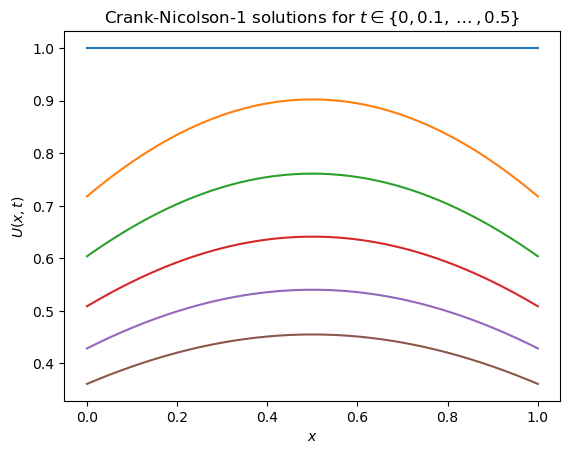

In [9]:
iStep = iMax // 5
for i in range(6):
    uVals = np.array( CN1_result[:,iStep*i] )
    plt.plot( xVals, uVals )

plt.xlabel( "$x$" )
plt.ylabel( "$U(x, t)$" )
plt.title( "Crank-Nicolson-1 solutions for $t \\in \\{0, 0.1, \\dots, 0.5\\}$" )
plt.show()

In [10]:
exact_result = np.zeros((jMax+1,iMax+1))
for i in range(iMax+1):
    for j in range(jMax+1):
        exact_result[j,i] = analyticSolution(xVals[j], tVals[i], alphaVals)

Here I calculate a measure of error &mdash; the _root mean square (RMS) error &mdash; that is an approximation to
$$
    R(t) = \left[\int_{0}^1 \left( U_{CN}(x,t) - U(x,t)\right)^2 \, dx \right]^{1/2}
$$
where $U_{CN}(x,t)$ is the Crank-Nicolson solution and $U(x,t)$ is the exact solution. I evaluate this at all times $t_i = i \times \Delta t$ for $i \in \{0, 1, \dots, \mbox{\texttt{iMax}}\}$.

In [16]:
diff1 = CN1_result - exact_result
rms_diff1 = np.sqrt(np.sum(diff1*diff1, axis=0)/(jMax + 1)) # finds RMS difference as a function of time
rms_diff1

array([0.        , 0.00537128, 0.00352214, 0.00291994, 0.00252002,
       0.00226361, 0.00205256, 0.00189588, 0.00175953, 0.00165283,
       0.00155871, 0.00148346, 0.00141664, 0.00136229, 0.00131346,
       0.00127284, 0.00123566, 0.00120383, 0.00117404, 0.00114774,
       0.00112259, 0.00109972, 0.00107746, 0.00105672, 0.00103629,
       0.0010169 , 0.00099765, 0.00097915, 0.00096071, 0.00094281,
       0.00092495, 0.00090752, 0.00089012, 0.00087306, 0.00085604,
       0.00083932, 0.00082263, 0.00080621, 0.00078985, 0.00077372,
       0.00075767, 0.00074182, 0.00072607, 0.00071052, 0.00069506,
       0.00067979, 0.00066463, 0.00064965, 0.00063479, 0.00062009,
       0.00060553, 0.00059113, 0.00057686, 0.00056275, 0.00054879,
       0.00053497, 0.00052132, 0.0005078 , 0.00049446, 0.00048125,
       0.00046823, 0.00045533, 0.00044263, 0.00043006, 0.0004177 ,
       0.00040546, 0.00039345, 0.00038157, 0.00036992, 0.00035841,
       0.00034716, 0.00033604, 0.0003252 , 0.00031452, 0.00030

# A second Crank-Nicolson scheme

The derivative approximation used above was only $O(\Delta x)$, while the Crank-Nicolson scheme is $O(\Delta x)$. It makes sense, then to try to use an $O(\Delta x^2)$ approximation to the derivative. A natural candidate is a centred-difference approximation. To do this, we introduce a fictitious grid point at $(-\Delta x, \, i \times \Delta t)$ and write formulae involving it.  The centred-difference approximation for the derivative is
$$
    \left. \frac{\partial U}{\partial x} \right|_{x=0, \, t=i\times\Delta t} \approx \frac{U^i_{1} - U^i_{-1}}{2 \Delta x}
$$
and so the boundary condition at $x=0$ becomes
$$
    \frac{U^i_{1} - U^i_{-1}}{2 \Delta x} = U^i_{0}
$$
which, after some rearrangement, yields
$$
    U^i_{-1} = U^i_{1} - 2 \Delta x U^i_{0}
$$

If we now demand that the PDE is satisfied at $(x=0, \, t=(i + 1/2)\times \Delta t)$ we get an equation that looks like
$$
    -r U^{i+1}_{-1} + 2(1 + r)U^{i+1}_{0} - rU^{i+1}_{1} = 
    rU^{i}_{-1} + 2(1 - r)U^{i}_{0} + rU^{i}_{1}.
$$
We can use our result from above to eliminate $U^i_{-1}$ and $U^{i+1}_{-1}$ to obtain
$$
    -r \left( U^{i+1}_{1} - 2 \Delta x U^{i+1}_{0}\right) + 2(1 + r)U^{i+1}_{0} - rU^{i+1}_{1} = 
    r\left( U^{i}_{1} - 2 \Delta x U^{i}_{0}\right) + 2(1 - r)U^{i}_{0} + rU^{i}_{1} 
$$
which simplifies to 
$$
    2(1 + r + r \Delta x)U^{i+1}_{0} - 2rU^{i+1}_{1} = 2(1 - r - r \Delta x)U^{i}_{0} + 2rU^{i}_{1}.
$$
This is of the form
$$
    b_0 U^{i+1}_0 + c_0 U^{i+1}_1 = d_0
$$
with
$$
    b_0 = 2(1 + r + r \Delta x), \;\;
    c_0 = -2r \qquad \mbox{and} \qquad 
    d_0 = 2(1 - r - r \Delta x)U^{i}_{0} + 2rU^{i}_{1},
$$
which we can incorporate into our tridiagonal system to impose the boundary condition at $x=0$.

Similar reasoning applied to the boundary condition at $x=1$ leads to 
$$
    a_{\texttt{jMax}} U^{i+1}_{\texttt{jMax-1}} + b_{\texttt{jMax}} U^{i+1}_{\texttt{jMax}} = d_{\texttt{jMax}}
$$
with
$$
    a_{\texttt{jMax}} = -2r, \;\;
    b_{\texttt{jMax}} = 2(1 + r + r \Delta x) \qquad \mbox{and} \qquad 
    d_{\texttt{jMax}} = 2(1 - r - r \Delta x)U^{i}_{\texttt{jMax}} + 2rU^{i}_{\texttt{jMax-1}}.
$$

In [12]:
def HeatEqn_CN2( iMax, jMax, tMax ):
    # Compute the step sizes and r
    xVals = np.linspace( 0.0, 1.0, (jMax + 1) )
    tVals = np.linspace( 0.0, tMax, (iMax + 1) )
    dx = xVals[1] - xVals[0]
    dt = tVals[1] - tVals[0]
    r = dt / (dx * dx) 

    # Set up storage for the tri-diagonal matrix A
    A_bands = np.zeros(shape=(3,jMax+1)) 
    
    # Set up a tuple that described the bands in our matrix
    u=1 # number of bands above the main diagonal
    l=1 # number of bands below the main diagonal
    l_and_u = (l, u) # needed for solve_banded()

    # Enforce the boundary condition at x=0
    A_bands[1,0] =  2.0*(1.0 + r + r*dx) # b_0 = 2(1 + r + r*dx)
    A_bands[0,1] = -2.0*r # c_0 = 2r
    
    # Set a[j], b[j] and c[j] for the middle rows
    for j in range(1,jMax):
        A_bands[2,j-1] = -r # a_j
        A_bands[1,j] = 2*(1.0+r) # b_j
        A_bands[0,j+1] = -r # c_j
        
    # Enforce the boundary condition at x=1
    A_bands[2,jMax-1] = -2.0*r # a_jMax = 2r
    A_bands[1,jMax] = 2.0*(1.0 + r + r*dx) # b_jMax = 2(1 + r + r*dx)

    # Initialize the result and allocate two scratch spaces
    result = np.zeros( (jMax+1,iMax+1) )
    uNow = np.zeros( jMax + 1 )
    uNext = np.zeros( jMax + 1 )

    # Install the initial condition
    for j in range(jMax+1):
        uNow[j] = 1.0
        result[j,0] = 1.0

    # Time step along
    d = np.zeros( jMax + 1 )
    for i in range(iMax):
        # Fill d with values depending on U^{i}_j, which are
        # stored in uNow[].
        d[0] =  2.0*(1 - r - r*dx)*uNow[0] + 2.0*r*uNow[1] # Boundary condition at x=0.
        for j in range(1,jMax):
            d[j] = 2.0*(1.0 - r)*uNow[j] + r*(uNow[j-1] + uNow[j+1])
            
        d[jMax] = 2.0*(1 - r - r*dx)*uNow[jMax] + 2.0*r*uNow[jMax-1] # Boundary condtion at x=1

        # Solve the tridiagonal system
        uNext = solve_banded( l_and_u, A_bands, d )
        
        # Record the result, then move on to the next step
        result[:,i+1] = uNext
        uNow = np.copy(uNext)

    # Return the results
    return xVals, tVals, result



In [13]:
xVals, tVals, CN2_result = HeatEqn_CN2( iMax, jMax, tMax )

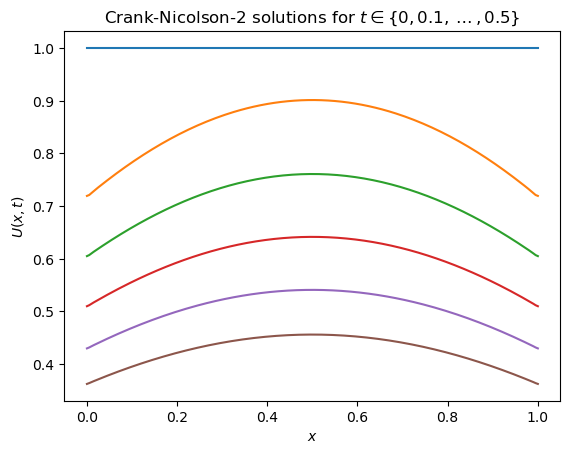

In [14]:
for i in range(6):
    uVals = np.array( CN2_result[:,iStep*i] )
    plt.plot( xVals, uVals )

plt.xlabel( "$x$" )
plt.ylabel( "$U(x, t)$" )
plt.title( "Crank-Nicolson-2 solutions for $t \\in \\{0, 0.1, \\dots, 0.5\\}$" )
plt.show()

In [15]:
diff2 = CN2_result - exact_result
rms_diff2 = np.sqrt(np.sum(diff2*diff2, axis=0)/(jMax + 1))
rms_diff2

array([0.00000000e+00, 2.02455990e-03, 1.23105229e-03, 9.77732969e-04,
       7.92539202e-04, 6.99143084e-04, 6.10656027e-04, 5.60292047e-04,
       5.06792849e-04, 4.74546926e-04, 4.38024865e-04, 4.15261906e-04,
       3.88324944e-04, 3.71200831e-04, 3.50227044e-04, 3.36765077e-04,
       3.19786217e-04, 3.08852756e-04, 2.94715621e-04, 2.85602782e-04,
       2.73587428e-04, 2.65825714e-04, 2.55456351e-04, 2.48721638e-04,
       2.39667336e-04, 2.33729775e-04, 2.25749863e-04, 2.20443265e-04,
       2.13356055e-04, 2.08558366e-04, 2.02222504e-04, 1.97842822e-04,
       1.92145705e-04, 1.88115409e-04, 1.82965693e-04, 1.79232272e-04,
       1.74554815e-04, 1.71077518e-04, 1.66809840e-04, 1.63556581e-04,
       1.59646286e-04, 1.56591419e-04, 1.52994273e-04, 1.50116985e-04,
       1.46795433e-04, 1.44078572e-04, 1.41000582e-04, 1.38429796e-04,
       1.35567928e-04, 1.33131037e-04, 1.30461700e-04, 1.28148219e-04,
       1.25651058e-04, 1.23451853e-04, 1.21109247e-04, 1.19016268e-04,
      

The RMS error is at all $t_i$ if we use the $O(\Delta x^2)$ approximation to the derivative.

In [20]:
# Compute the ratio of RMS errors, skipping the initial condition as both
# approaches compute this exactly.
err_ratio = rms_diff2[1:(iMax+1)] / rms_diff1[1:(iMax+1)]
err_ratio

array([0.37692306, 0.3495178 , 0.33484722, 0.31449781, 0.30886189,
       0.29750985, 0.29553113, 0.28802747, 0.28711134, 0.28101789,
       0.27992793, 0.2741167 , 0.27248211, 0.26664439, 0.26457742,
       0.25879844, 0.25655787, 0.25102593, 0.24883884, 0.24371138,
       0.24172229, 0.23709198, 0.23537189, 0.23127504, 0.22984604,
       0.22628125, 0.22513826, 0.22208279, 0.22120838, 0.21862956,
       0.21800269, 0.21586496, 0.21546561, 0.21373453, 0.21354584,
       0.21219013, 0.21219921, 0.21119174, 0.21138971, 0.21070778,
       0.21108958, 0.21071493, 0.21127901, 0.21119764, 0.21194561,
       0.21214761, 0.21308397, 0.21356328, 0.21469528, 0.21544951,
       0.21678697, 0.21781728, 0.21937256, 0.22068358, 0.22247156,
       0.22407124, 0.22610934, 0.22800895, 0.23031715, 0.23253113,
       0.23513191, 0.23767769, 0.2405959 , 0.24349355, 0.24675597,
       0.25002753, 0.25366216, 0.25733044, 0.26136503, 0.26545166,
       0.26991129, 0.27443339, 0.27933642, 0.28430146, 0.28965